In [1]:
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 8)})

In [2]:
dataset = read_lang_dataset("data/codes_new.db")
dataset

,language,code
0,Python,"""""""The tests for the automation component.""""""\..."
1,Python,#!python2\n# -*- coding: utf-8 -*-\nimport os\...
2,Python,#!/usr/bin/python\n#\n# Copyright (c) 2017 Yuw...
3,Python,"""""""The tests for the Template automation.""""""\n..."
4,Python,"""""""The tests for numeric state automation.""""""\..."
...,...,...
4694,Python,# coding=utf-8\n# Copyright 2020 The HuggingFa...
4695,Python,#! /usr/bin/env python\n\n# Author: David Good...
4696,Python,"from enum import Enum, auto\nfrom typing impor..."
4697,Python,"""""""Define action data and record.""""""\n\n# Offi..."


In [3]:
dataset.language.value_counts()

Go        2203
Python    1383
C#        1113
Name: language, dtype: int64

In [4]:
tokenized_sample = tokenize_dataset(dataset)
tokenized_sample

100%|██████████| 2203/2203 [01:39<00:00, 22.22it/s]


,language,code
0,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
1,Python,"[\n, import, os, \n, import, sys, \n, import, ..."
2,Python,"[\n, from, __future__, import, absolute_import..."
3,Python,"[STRING_LITERAL, \n, import, unittest, \n, fro..."
4,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
...,...,...
4694,Python,"[\n, import, copy, \n, import, sys, \n, import..."
4695,Python,"[\n, STRING_LITERAL, \n, from, __init__, impor..."
4696,Python,"[from, enum, import, Enum, ,, auto, \n, from, ..."
4697,Python,"[STRING_LITERAL, \n, from, dataclasses, import..."


In [6]:
def create_lang_model(dataset, complete_model, language):
    model = Word2Vec.load("models/complete_model.gensim")
    #model = Word2Vec(vector_size=100, window=10, min_count=10, workers=4)
    #model.reset_from(complete_model)
    model.init_weights()
    train_dataset = dataset.code[dataset.language == language]
    model.train(train_dataset, total_examples=len(train_dataset), epochs=10)
    return model

In [8]:
complete_model = Word2Vec(vector_size=100, window=10, min_count=10, workers=8)
complete_model.build_vocab(tokenized_sample.code)
complete_model.save("models/complete_model.gensim")
models = [(language, create_lang_model(tokenized_sample, complete_model, language)) for language in tokenized_sample.language.unique()]
models

[('Python', <gensim.models.word2vec.Word2Vec at 0x25cae0c7e80>),
 ('C#', <gensim.models.word2vec.Word2Vec at 0x25cae0c73a0>),
 ('Go', <gensim.models.word2vec.Word2Vec at 0x25cad9c4dc0>)]

# Visualize

In [17]:
from gensim.models import TranslationMatrix


inserted_tokens = ["INT_LITERAL", "FLOAT_LITERAL", "STRING_LITERAL", "VARIABLE"]
math_ops = ["+", "-", "*", "/", "%"]
common_keywords = ["if", "else", "for", "while"]
python_keywords = ["def", "class", "return", "if", "else", "for", "while", "in", "import", "from", "as", "with", "try", "except", "finally", "raise", "assert", "yield", "lambda", "pass", "break", "continue", "del", "global", "nonlocal", "and", "or", "not", "is", "in", "True", "False", "None", "async", "await"]
cpp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
csharp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
go_keywords = ["break", "func", "default", "type", "defer", "go", "struct", "map", "chan", "else", "goto", "package", "range", "const", "fallthrough", "for", "import", "interface", "return", "select", "case", "continue", "if", "switch", "var", "nil", "true", "false"]

In [51]:
# TODO: vectors are different for models so we have to align them, currently we just use least square method
#  maybe removing mean vector or something can help.
def word_cloud(models: List[Tuple[str, Word2Vec]], words, translation_fix_words):
    words = list(set(words))
    translation_target = models[0][1].wv[translation_fix_words]
    df = pd.DataFrame(columns=["model", "word", "x", "y"])
    for name, model in models:
        translation_source = model.wv[translation_fix_words]
        translation_matrix = np.linalg.lstsq(translation_source, translation_target, rcond=None)[0]
        existing_words = [word for word in words if word in model.wv]
        vecs = [model.wv[word] @ translation_matrix for word in existing_words]
        vecs = np.asarray(vecs)
        df = df.append(pd.DataFrame({"model": [name] * len(existing_words), "word": existing_words, "x": vecs[:, 0], "y": vecs[:, 1]}))

    # visulize 2D with dimensionality reductino
    pca = PCA(2, whiten=True)
    df[["x", "y"]] = pca.fit_transform(df[["x", "y"]])
    ax = sns.scatterplot(data=df, x="x", y="y", hue="model")
    range_x, range_y = np.ptp(df[["x", "y"]], axis=0)
    for m in df.model.unique():
        model_df = df[df.model == m]
        for model, word, x, y in model_df.itertuples(index=False):
            ax.text(x + 0.005 * range_x, y, word,
                verticalalignment='center', horizontalalignment='left', fontsize=8)
    return ax

C:\Users\Kevin\AppData\Local\Temp\ipykernel_17416\1721258809.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"model": [name] * len(existing_words), "word": existing_words, "x": vecs[:, 0], "y": vecs[:, 1]}))
C:\Users\Kevin\AppData\Local\Temp\ipykernel_17416\1721258809.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"model": [name] * len(existing_words), "word": existing_words, "x": vecs[:, 0], "y": vecs[:, 1]}))
C:\Users\Kevin\AppData\Local\Temp\ipykernel_17416\1721258809.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({"model": [name] * len(existing_words), "word": existing_words, "x": vecs[:, 0], "y": vecs[:, 1]}))


<AxesSubplot: xlabel='x', ylabel='y'>

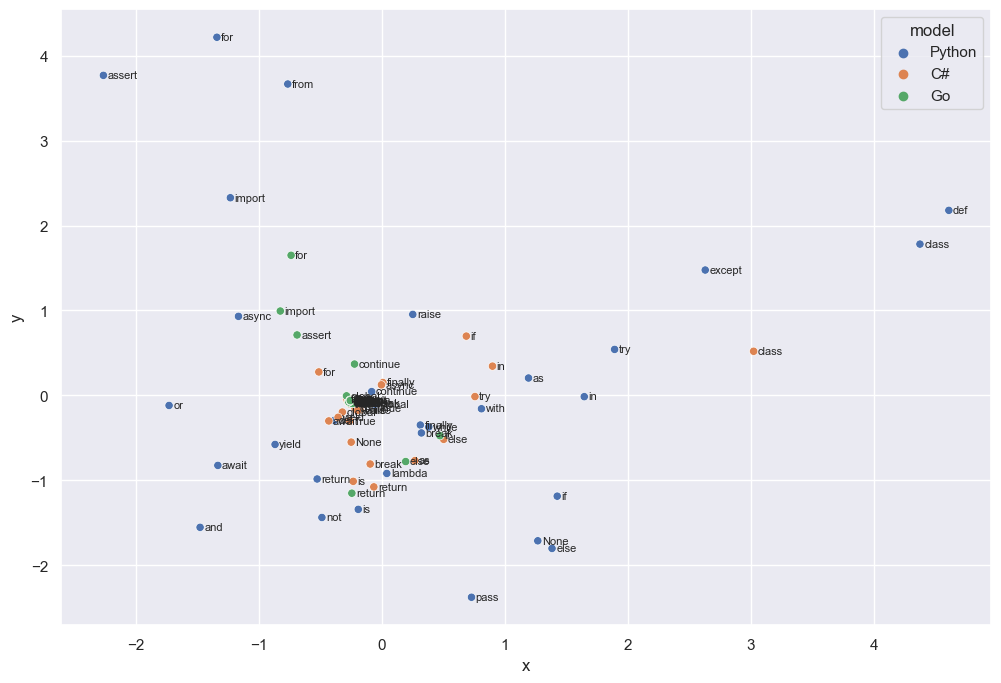

In [52]:
word_cloud(models, python_keywords + common_keywords, [w for w in complete_model.wv.key_to_index.keys()])